In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
%matplotlib inline
from os import listdir
from PIL import Image
import glob
import os
import scipy.misc #to save failed images in 3 channel images
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

#define global variables for previous frame data and moving window arrays
prev_left_fit = np.zeros(3)
prev_right_fit = np.zeros(3)
prev_leftx_base = 0
prev_rightx_base = 0
mw_leftx_base = np.zeros(3)
mw_rightx_base = np.zeros(3)
icount = 1
total_fail = 0

def calibrate_camera():
    #Camera calibration
    #define directory where camera calibration images (checkerboards) are located in
    images = glob.glob('camera_cal/calibration*.jpg')
 
    objpoints = [] #3D points in real world space
    imgpoints = [] #2D points in image plane
    
    #define nx and ny
    nx = 9 #0~9 total 10 squares in x direction
    ny = 6 #0~6 total 7 squares in y direction
    
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1, 2)

    for fname in images:
        img = mpimg.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)            

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
       
    return mtx, dist

#define undistort image function
def undistort(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

#advanced perspective transform, also as part of the transform process, data other than point of interest is masked (getting rid of the hood and environment)
def perspective_transform(img):    
    # Grab the image shape
    img_size = (img.shape[1], img.shape[0])

    #from the straight line image, pick out four corners to be the basis for perspective transformation
    #570,465	712,465
    #238,689	1070,689  
    #corner designations in src go in clockwise direction starting from the left top corner
    src = np.float32([[570,465],[712,465],[1070,689],[238,689]])
    
    # For destination points, pick out a good four rectangular corner points, with enough offset so that curved lines won't get cut off
    offset = 200 # horizontal offset for dst points    
    #corner designations in dst go in clockwise direction starting from the left top corner
    dst = np.float32([[offset, 0], [img_size[0]-offset, 0], [img_size[0]-offset, img_size[1]], [offset, img_size[1]]])
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)

    # Return the resulting image and matrix
    return warped, M, Minv

#color threshold with hls
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

#color threshold with hls
def hsv_select(img, thresh=(0, 255)):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hsv[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
def get_curvature(binary_warped, left_fit, right_fit):      
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    #define y_eval as the bottom of the image, which should be 720
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    y_eval = np.max(ploty) * ym_per_pix
       
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    return left_curverad, right_curverad

def get_lanecenter(binary_warped, left_fit, right_fit):
    #define y_eval as the bottom of the image, which should be 720
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    y_eval = np.max(ploty)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
  
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    img_size = (binary_warped.shape[1], binary_warped.shape[0])
    
    lane_center = (left_fitx[719] + right_fitx[719])/2
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    center_offset_pixels = (img_size[0]/2) - lane_center
    center_offset_mtrs = xm_per_pix*center_offset_pixels
    
    return center_offset_mtrs

def fit_lines(binary_warped):
    #connect global variables
    global prev_leftx_base
    global prev_rightx_base
    global mw_leftx_base
    global mw_rightx_base
    
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    #perform moving average with arctan for leftx_base    
    if (mw_leftx_base[1]+mw_leftx_base[2]) == 0.:
        #copy mw_leftx_base[0] onto [1] and [2] for the first time
        mw_leftx_base[0] = leftx_base
        mw_leftx_base[2] = mw_leftx_base[0]
        mw_leftx_base[1] = mw_leftx_base[0]
    else:
        #shift to the right
        mw_leftx_base[2] = mw_leftx_base[1]
        mw_leftx_base[1] = mw_leftx_base[0]
        mw_leftx_base[0] = leftx_base    
    #compute average leftx_base position of the 3 moving average array
    avg_leftx_base = (sum(mw_leftx_base)/len(mw_leftx_base)).astype(int)
    if prev_leftx_base == 0:
        final_leftx_base = avg_leftx_base
    else:            
        #allow a maximum of 5 pixels change
        final_leftx_base = (prev_leftx_base + (5*np.tanh(0.1*(avg_leftx_base-prev_leftx_base)))).astype(int)
    #update prev_left_x_base
    prev_leftx_base = final_leftx_base
        
    #perform moving average with arctan for rightx_base    
    if (mw_rightx_base[1]+mw_rightx_base[2]) == 0.:
        #copy mw_rightx_base[0] onto [1] and [2] for the first time
        mw_rightx_base[0] = rightx_base        
        mw_rightx_base[2] = mw_rightx_base[0]
        mw_rightx_base[1] = mw_rightx_base[0]
    else:
        #shift to the right
        mw_rightx_base[2] = mw_rightx_base[1]
        mw_rightx_base[1] = mw_rightx_base[0]
        mw_rightx_base[0] = rightx_base
    #compute average rightx_base position of the 3 moving average array
    avg_rightx_base = (sum(mw_rightx_base)/len(mw_rightx_base)).astype(int)
    if prev_rightx_base == 0:
        final_rightx_base = avg_rightx_base
    else:            
        final_rightx_base = (prev_rightx_base + (5*np.tanh(0.1*(avg_rightx_base-prev_rightx_base)))).astype(int)
    #update prev_right_x_base
    prev_rightx_base = final_rightx_base
       

    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = final_leftx_base.astype(int)
    rightx_current = final_rightx_base.astype(int)
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
        
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit

def plot_windows(binary_warped,left_fit,right_fit):
    #connect global variables
    global prev_leftx_base
    global prev_rightx_base
    global mw_leftx_base
    global mw_rightx_base
    
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    #perform moving average with arctan for leftx_base    
    if (mw_leftx_base[1]+mw_leftx_base[2]) == 0.:
        #copy mw_leftx_base[0] onto [1] and [2] for the first time
        mw_leftx_base[0] = leftx_base
        mw_leftx_base[2] = mw_leftx_base[0]
        mw_leftx_base[1] = mw_leftx_base[0]
    else:
        #shift to the right
        mw_leftx_base[2] = mw_leftx_base[1]
        mw_leftx_base[1] = mw_leftx_base[0]
        mw_leftx_base[0] = leftx_base    
    #compute average leftx_base position of the 3 moving average array
    avg_leftx_base = (sum(mw_leftx_base)/len(mw_leftx_base)).astype(int)
    if prev_leftx_base == 0:
        final_leftx_base = avg_leftx_base
    else:            
        #allow a maximum of 5 pixels change
        final_leftx_base = (prev_leftx_base + (5*np.tanh(0.1*(avg_leftx_base-prev_leftx_base)))).astype(int)
    #update prev_left_x_base
    prev_leftx_base = final_leftx_base
        
    #perform moving average with arctan for rightx_base    
    if (mw_rightx_base[1]+mw_rightx_base[2]) == 0.:
        #copy mw_rightx_base[0] onto [1] and [2] for the first time
        mw_rightx_base[0] = rightx_base        
        mw_rightx_base[2] = mw_rightx_base[0]
        mw_rightx_base[1] = mw_rightx_base[0]
    else:
        #shift to the right
        mw_rightx_base[2] = mw_rightx_base[1]
        mw_rightx_base[1] = mw_rightx_base[0]
        mw_rightx_base[0] = rightx_base
    #compute average rightx_base position of the 3 moving average array
    avg_rightx_base = (sum(mw_rightx_base)/len(mw_rightx_base)).astype(int)
    if prev_rightx_base == 0:
        final_rightx_base = avg_rightx_base
    else:            
        final_rightx_base = (prev_rightx_base + (5*np.tanh(0.1*(avg_rightx_base-prev_rightx_base)))).astype(int)
    #update prev_right_x_base
    prev_rightx_base = final_rightx_base
       

    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = final_leftx_base.astype(int)
    rightx_current = final_rightx_base.astype(int)
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean positionsave
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
        
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
    plt.savefig('output_images/plot_fit_lines_windows.png')

def fit_nextlines(binary_warped, left_fit, right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit

# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', sobel_kernel=5, thresh=(0,255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

#the following function handles drawing green mask between the lines onto the input img frame
def save_mask(img, binary_warped, left_fit, right_fit, Minv):
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
   
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(out_img, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(out_img, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)     
        
    return result

def filter(undist):
    sobel_thresh = (25, 255)    
    S_thresh = (80, 255)
    H_thresh= (20, 30)

    x_binary = abs_sobel_thresh(undist, 'x', 5, sobel_thresh)
    y_binary = abs_sobel_thresh(undist, 'y', 3, sobel_thresh)
    S_binary = HLS_threshold(undist, 'S', S_thresh)
    H_binary = HLS_threshold(undist, 'H', H_thresh)
    W_binary = white_selector(undist)
    Y_binary = yellow_selector(undist)

    color_output = OR_binaries(OR_binaries(W_binary, Y_binary), AND_binaries(S_binary, H_binary))
    grad_output = blur = cv2.GaussianBlur(AND_binaries(x_binary, y_binary),(5,5),0)
    filtered = OR_binaries(color_output, grad_output)
    
    return filtered

#define the pipeline within process_image function which will be run by video module for every frame
def process_image(image):
    #connect global variables
    global prev_left_fit
    global prev_right_fit
    global mw_left_fit
    global mw_right_fit
    global total_fail
    
    #build my pipeline here     
    
    #undistort
    undist = undistort(image,mtx,dist)
    
    #apply sobel x, sobel diretional, S & H color thresholding, white and yellow color extraction techniques to filter the images
    filtered = filter(undist)    

    #do perspective transform and get point of interest at the same time
    binary_warped, M, Minv = perspective_transform(filtered)
    
    #sliding window fit lines
    left_fit, right_fit = fit_lines(binary_warped)    
          
    #measure curvature initially
    left_curve_rad, right_curve_rad = get_curvature(binary_warped,left_fit,right_fit)
    
    #measure lane center initially
    lane_center = get_lanecenter(binary_warped, left_fit, right_fit)
    
    #sanitycheck with curvature data
    if abs(left_curve_rad - right_curve_rad) > 2000:
        if((sum(prev_left_fit) + sum(prev_right_fit) == 0)):
            prev_left_fit = left_fit
            prev_right_fit = right_fit
#         print("left_curve_rad: {}".format(left_curve_rad))
#         print("right_curve_rad: {}".format(right_curve_rad))   
        #use last frame's values if sanity check fails
#         print("current left_fit: {}".format(left_fit))
#         print("current right_fit: {}".format(right_fit))
        left_fit = prev_left_fit
        right_fit = prev_right_fit
#         print("replacing left_fit: {}".format(left_fit))
#         print("replacing right_fit: {}".format(right_fit))
        result = save_mask(image, binary_warped, left_fit, right_fit, Minv)  
#         f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
#         f.tight_layout()
#         ax1.imshow(image)
#         ax1.set_title('original', fontsize=50)
#         ax2.imshow(binary_warped, cmap='gray')
#         ax2.set_title('binary_warped', fontsize=50)
#         plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
#         global icount
#         scipy.misc.toimage(image).save("failed_images/failed%s.jpg" %icount)
#         #mpimg.imsave("failed_images/failed%s.jpg" %icount, image)
#         icount = icount+1
        total_fail = total_fail + 1
    else:
        #save into previous frame global variables if sanity check is okay
        prev_left_fit = left_fit
        prev_right_fit = right_fit    
    
    #draw the lanes
    result = save_mask(image, binary_warped, left_fit, right_fit, Minv)   
    
    #measure curvature initially
    left_curve_rad, right_curve_rad = get_curvature(binary_warped,left_fit,right_fit)
    average_curve_rad = (left_curve_rad + right_curve_rad)/2
    
    #measure lane center initially
    lane_center = get_lanecenter(binary_warped, left_fit, right_fit)
    
    #Add text to image
    cv2.putText(result,"Offset: {:0.2f} m.".format(lane_center), (50,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2, cv2.LINE_AA)
    cv2.putText(result,"Radius of Curvature: {:0.2f} m.".format(average_curve_rad), (50,140), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2, cv2.LINE_AA)
        
    return result

def yellow_selector(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    lower_yellow_threshold = np.asarray([10, 100, 100])
    upper_yellow_threshold = np.asarray([50, 255, 255])
    binary_img = cv2.inRange(img, lower_yellow_threshold, upper_yellow_threshold) / 255
    binary_img = binary_img.astype(np.uint8)
    return binary_img
    #return np.array(binary_img, dtype=np.uint8)

def white_selector(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    lower_white_threshold = np.array([0,0,200], dtype = np.uint8)
    upper_white_threshold = np.array([255,30,255], dtype = np.uint8)
    binary_img = cv2.inRange(img, lower_white_threshold, upper_white_threshold) / 255
    binary_img = binary_img.astype(np.uint8)
    return binary_img

def OR_binaries(img1, img2):
    new_img = np.zeros_like(img1)
    new_img[(img1 == 1) | (img2 == 1)] = 1
    return new_img

def AND_binaries(img1, img2):
    new_img = np.zeros_like(img1)
    new_img[(img1 == 1) & (img2 == 1)] = 1
    return new_img

def HLS_threshold(img, channel='S', thresh=(0,255)):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    H,L,S = cv2.split(img)
    binary_img = np.zeros_like(S)
    if channel == 'S':
        #binary_img = cvtThresholdBinary(S, thresh)
        binary_img[(S > thresh[0]) & (S <= thresh[1])] = 1
    elif channel == 'H':
        #binary_img = cvtThresholdBinary(H, thresh)
        binary_img[(H > thresh[0]) & (H <= thresh[1])] = 1
    else:
        print("ERROR: Incorrect channel selected, empty image returned")
    return binary_img

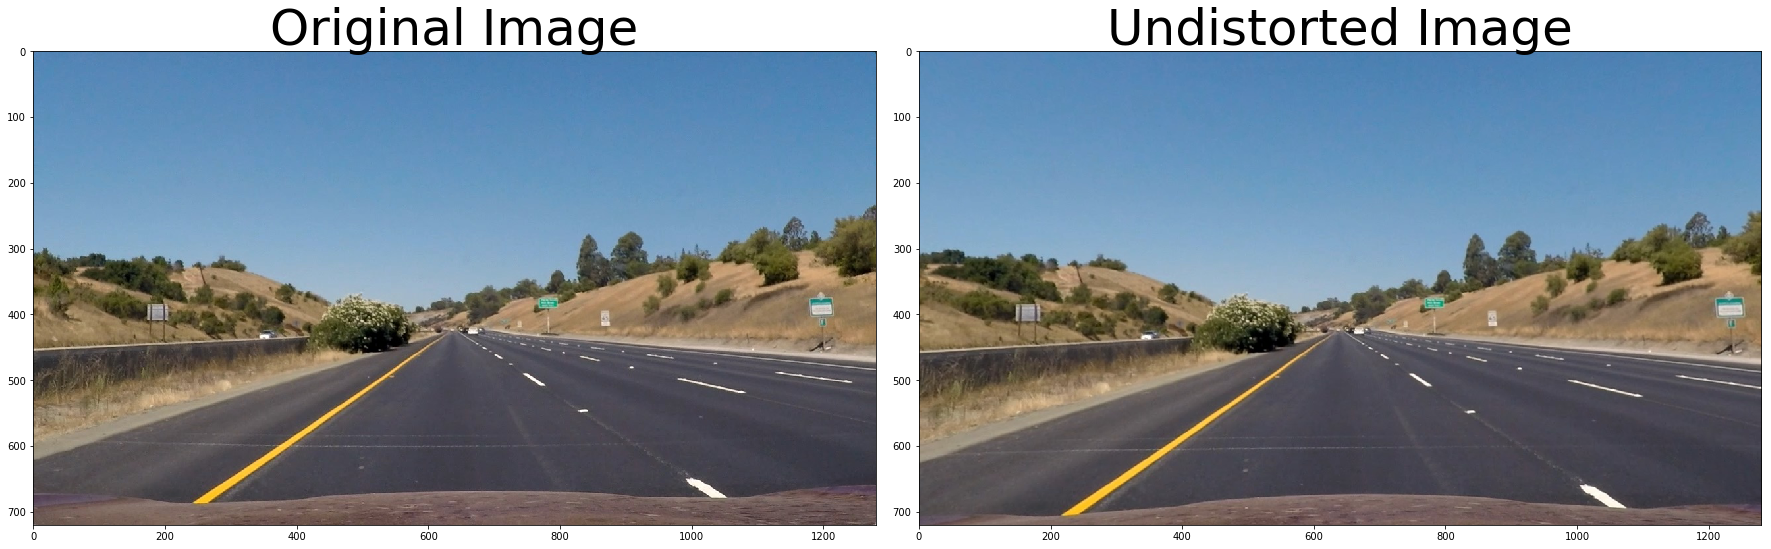

In [2]:
#initialize global variables
prev_left_fit = np.zeros(3)
prev_right_fit = np.zeros(3)
prev_leftx_base = 0
prev_rightx_base = 0
mw_leftx_base = np.zeros(3)
mw_rightx_base = np.zeros(3)
total_fail = 0

#test undistort function
#testimg = cv2.imread('camera_cal/calibration1.jpg')
testimg = mpimg.imread('test_images/straight_lines1.jpg')
mtx, dist = calibrate_camera()
undist = undistort(testimg,mtx,dist)
mpimg.imsave("output_images/undist_straight_lines1.jpg", undist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(testimg)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/orig_undist.png')


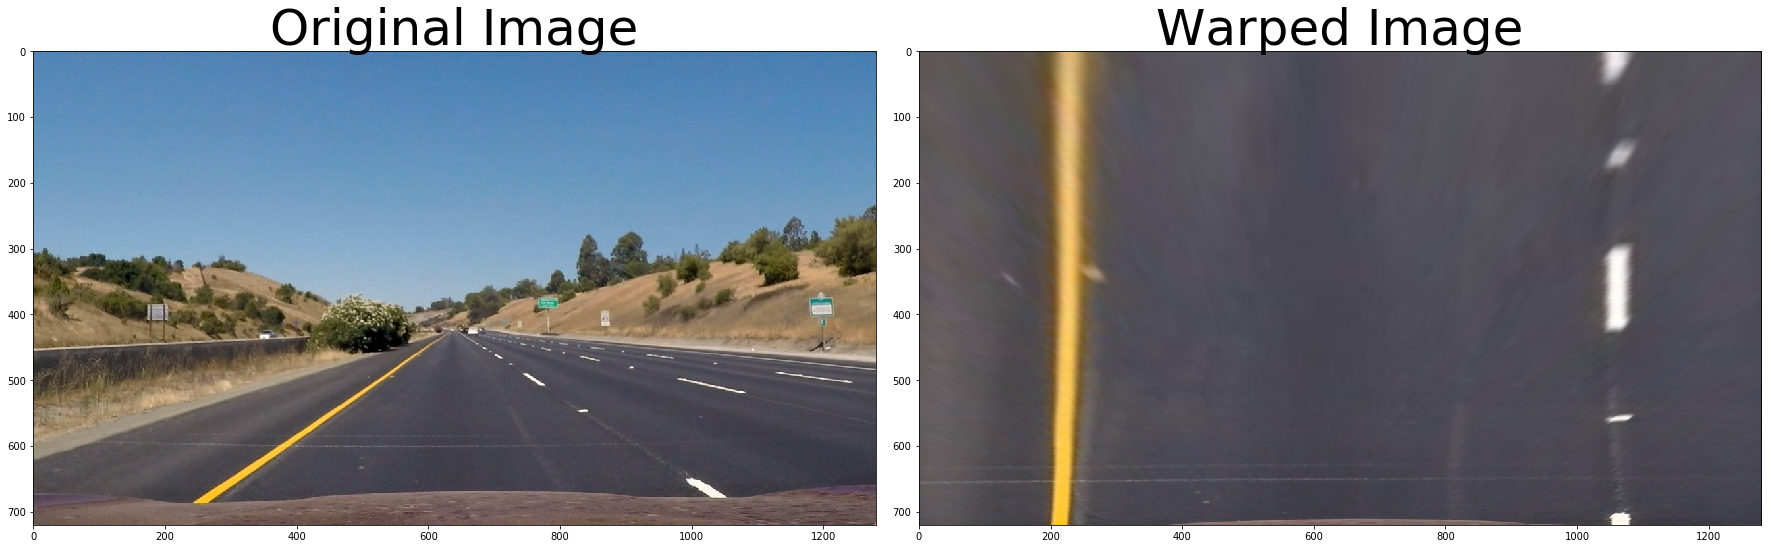

In [3]:
#initialize global variables
prev_left_fit = np.zeros(3)
prev_right_fit = np.zeros(3)
prev_leftx_base = 0
prev_rightx_base = 0
mw_leftx_base = np.zeros(3)
mw_rightx_base = np.zeros(3)
total_fail = 0

#test perspective_transform function
testimg = mpimg.imread('test_images/straight_lines1.jpg')
mtx, dist = calibrate_camera()
undist = undistort(testimg,mtx,dist)
warped, M, Minv = perspective_transform(undist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(testimg)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped, cmap='gray')
ax2.set_title('Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/orig_warped.png')

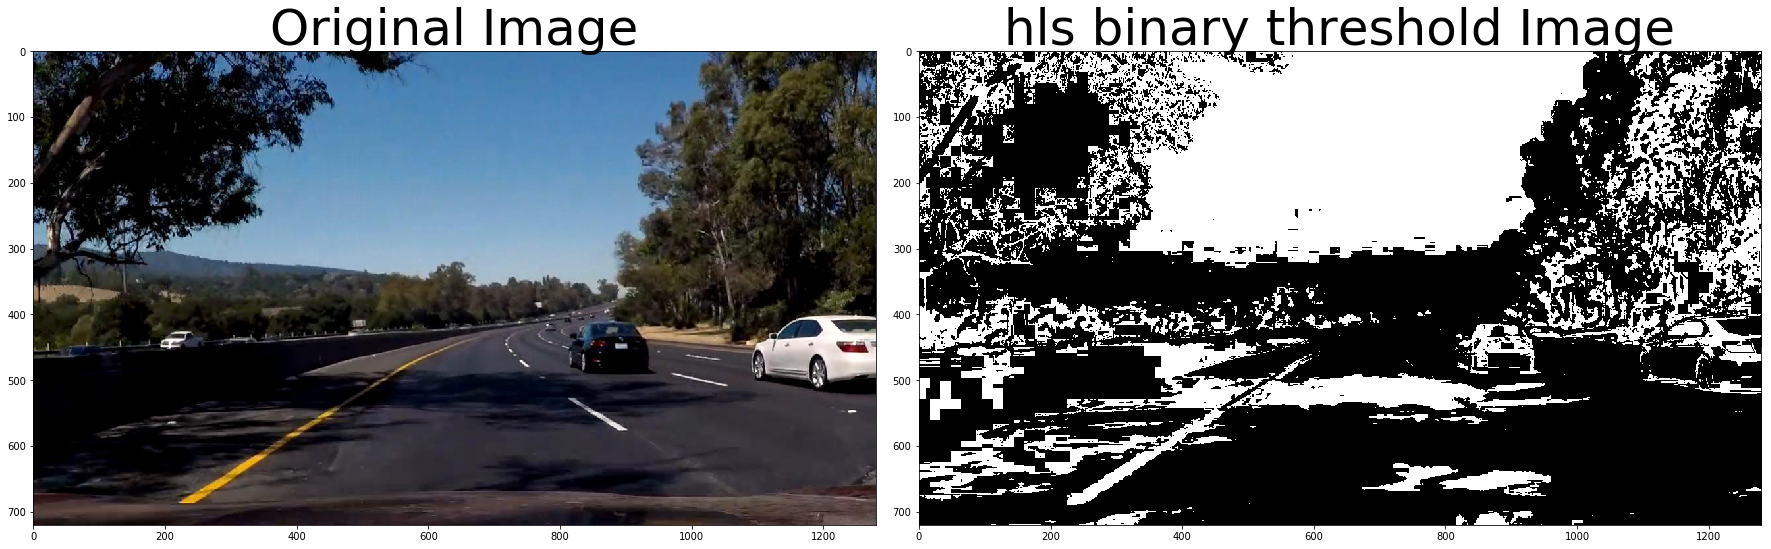

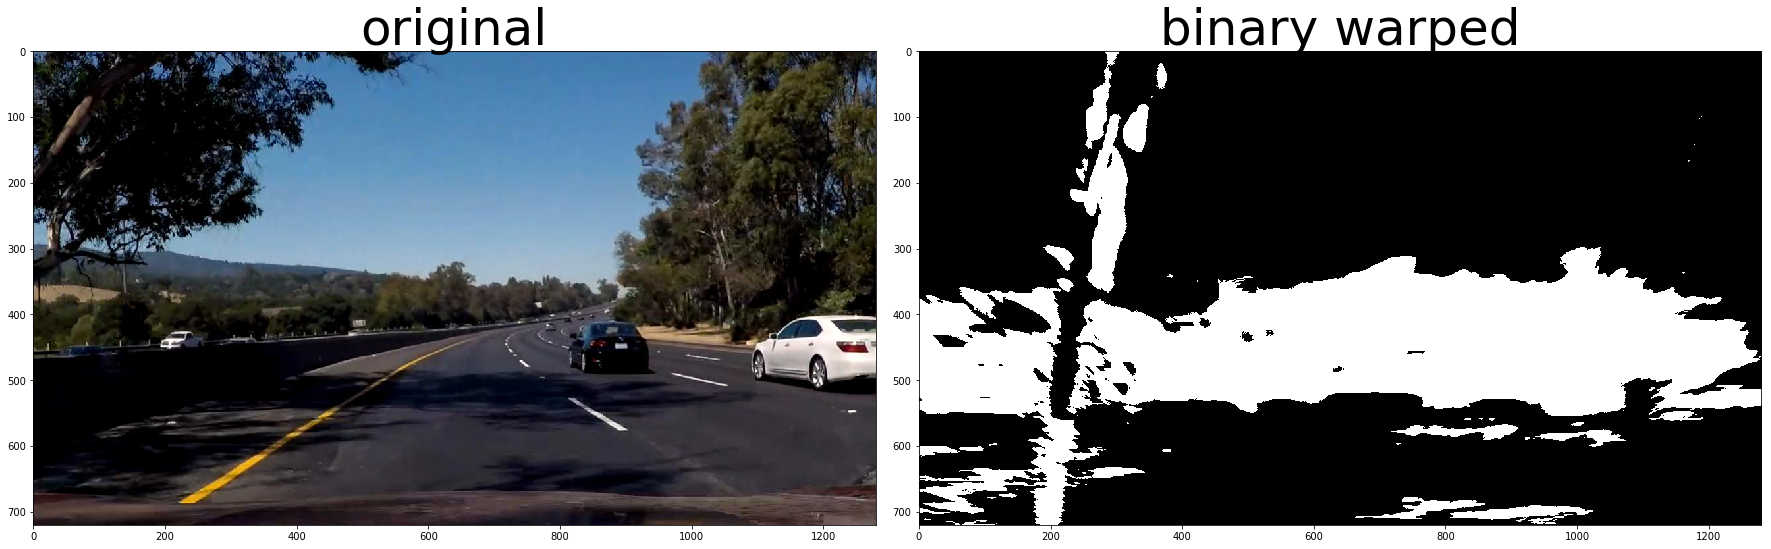

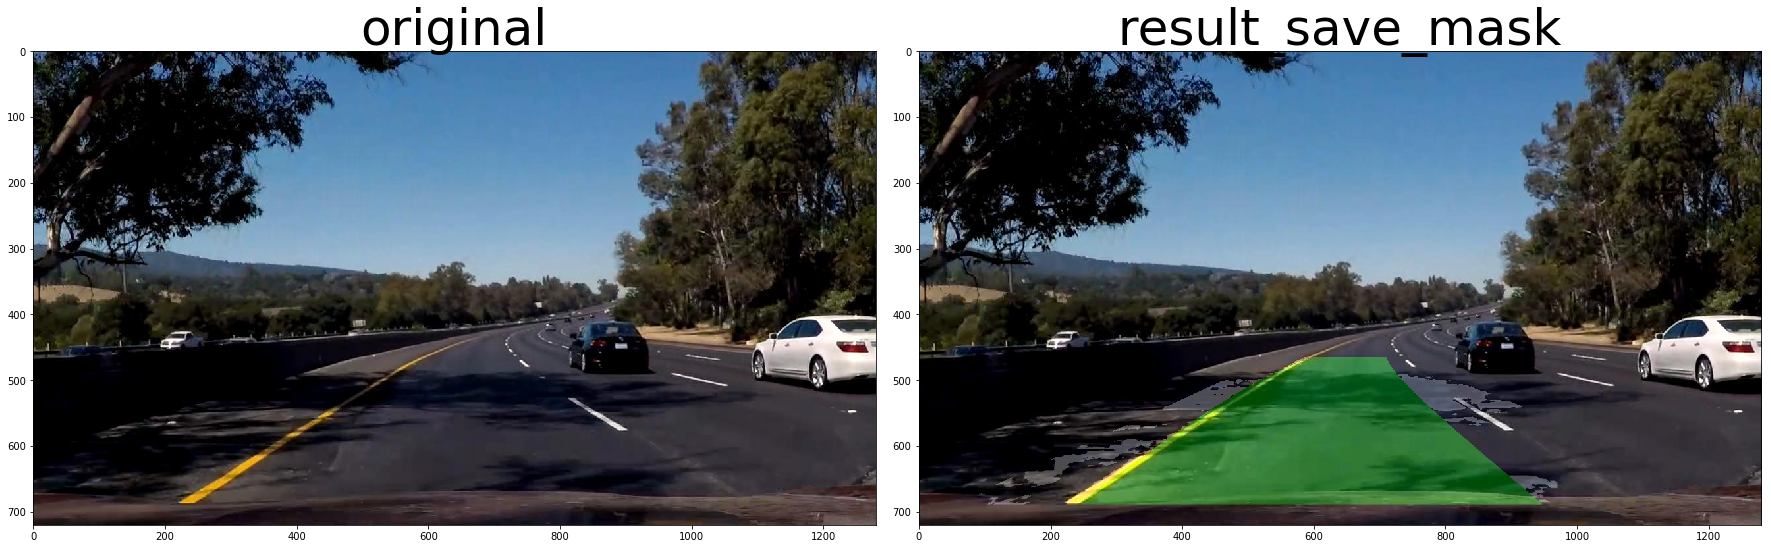

In [4]:
#initialize global variables
prev_left_fit = np.zeros(3)
prev_right_fit = np.zeros(3)
prev_leftx_base = 0
prev_rightx_base = 0
mw_leftx_base = np.zeros(3)
mw_rightx_base = np.zeros(3)
total_fail = 0

#test hls_select function
testimg = mpimg.imread('failed_images/failed290.jpg')
mtx, dist = calibrate_camera()
undist = undistort(testimg,mtx,dist)
warped, M, Minv = perspective_transform(undist)

#hls_binary = hls_select(warped, thresh=(90, 255))
hls_binary = hls_select(testimg, thresh=(90, 255))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(testimg)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(hls_binary, cmap='gray')
ax2.set_title('hls binary threshold Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/orig_hlsbinary.png')

binary_warped = hls_select(warped, thresh=(90, 255))
left_fit, right_fit = fit_lines(binary_warped)
prev_left_fit = left_fit
prev_right_fit = right_fit
result = save_mask(testimg, binary_warped, left_fit, right_fit, Minv)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(testimg)
ax1.set_title('original', fontsize=50)
ax2.imshow(binary_warped, cmap='gray')
ax2.set_title('binary warped', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/orig_binarywarped_beforefilter.png')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(testimg)
ax1.set_title('original', fontsize=50)
ax2.imshow(result, cmap='gray')
ax2.set_title('result_save_mask', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/orig_result_beforefilter.png')


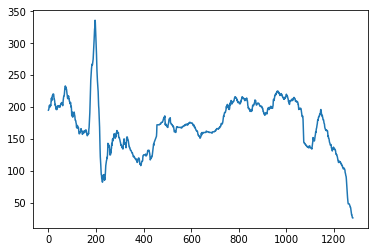

In [5]:
#initialize global variables
prev_left_fit = np.zeros(3)
prev_right_fit = np.zeros(3)
prev_leftx_base = 0
prev_rightx_base = 0
mw_leftx_base = np.zeros(3)
mw_rightx_base = np.zeros(3)
total_fail = 0

#histogram test with just S channel select threshold
testimg = mpimg.imread('failed_images/failed290.jpg')
mtx, dist = calibrate_camera()
undist = undistort(testimg,mtx,dist)
warped, M, Minv = perspective_transform(undist)
hls_binary = hls_select(warped, thresh=(90, 255))

img = hls_binary

histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
plt.plot(histogram)
plt.savefig('output_images/histogram_Schannelonly.png')

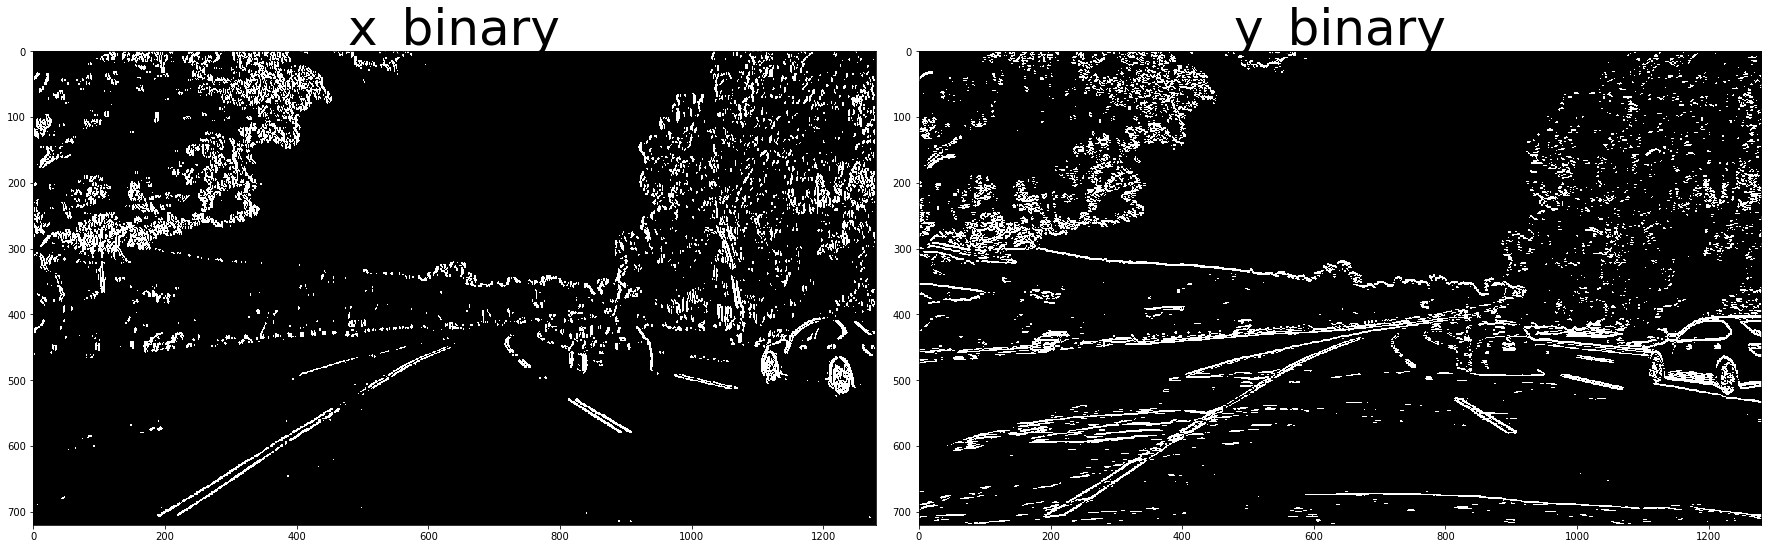

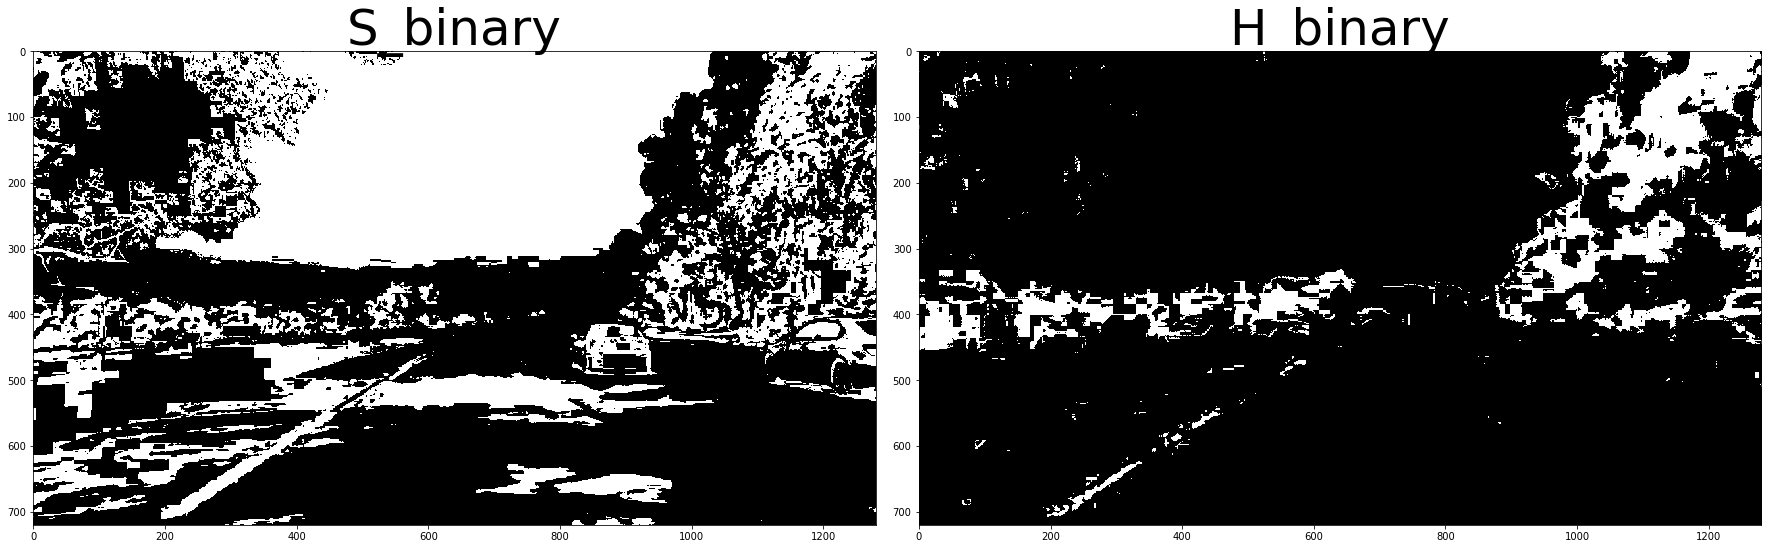

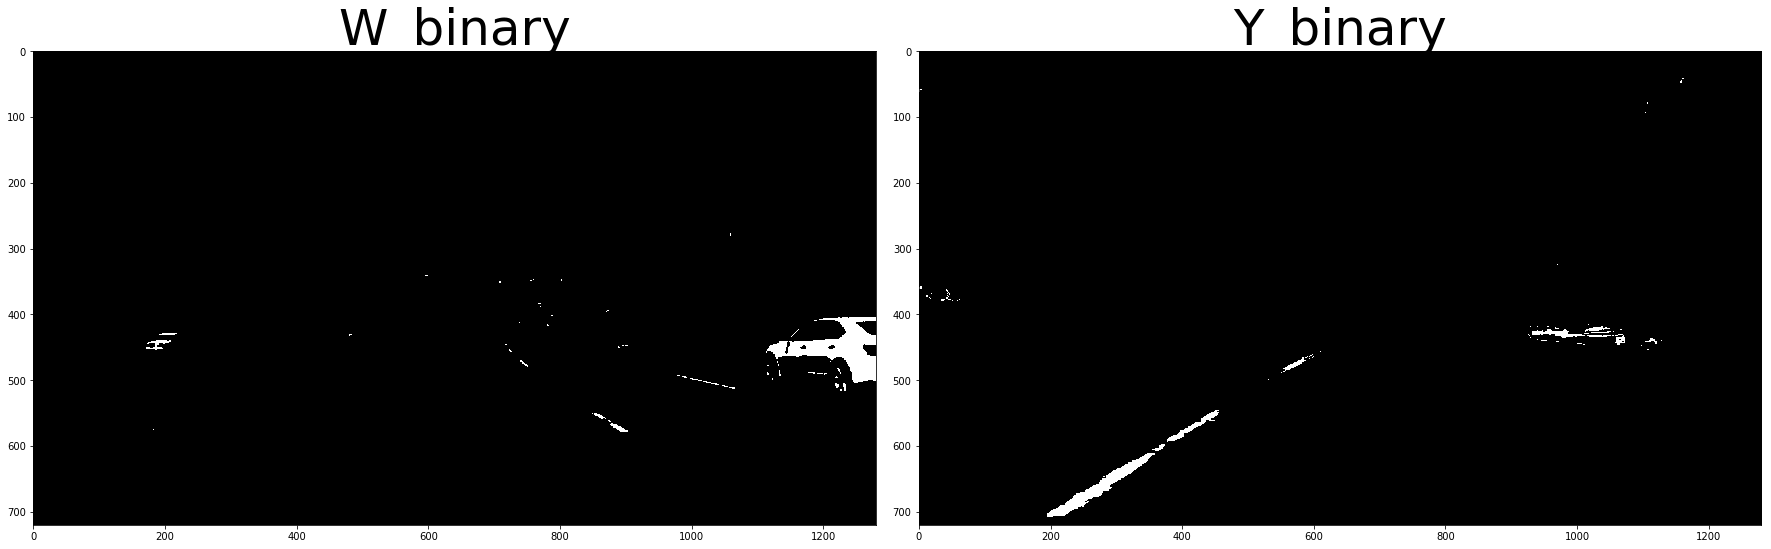

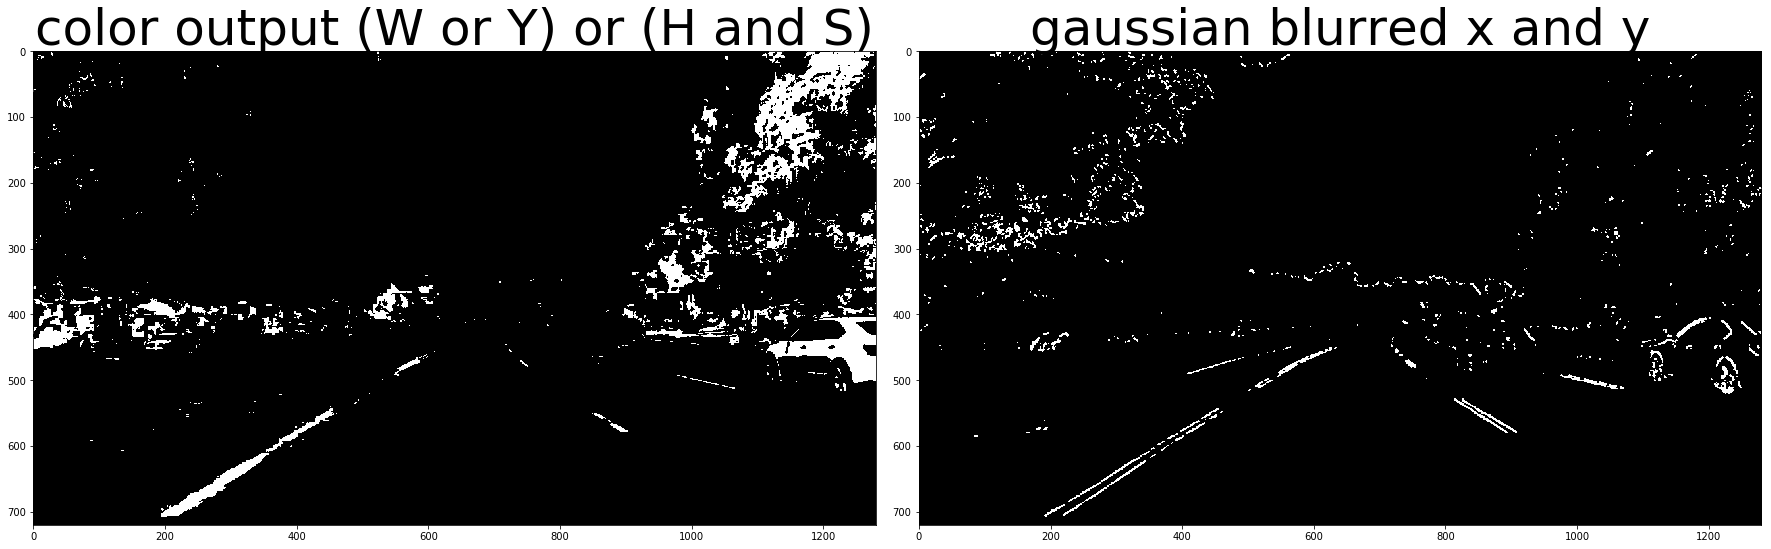

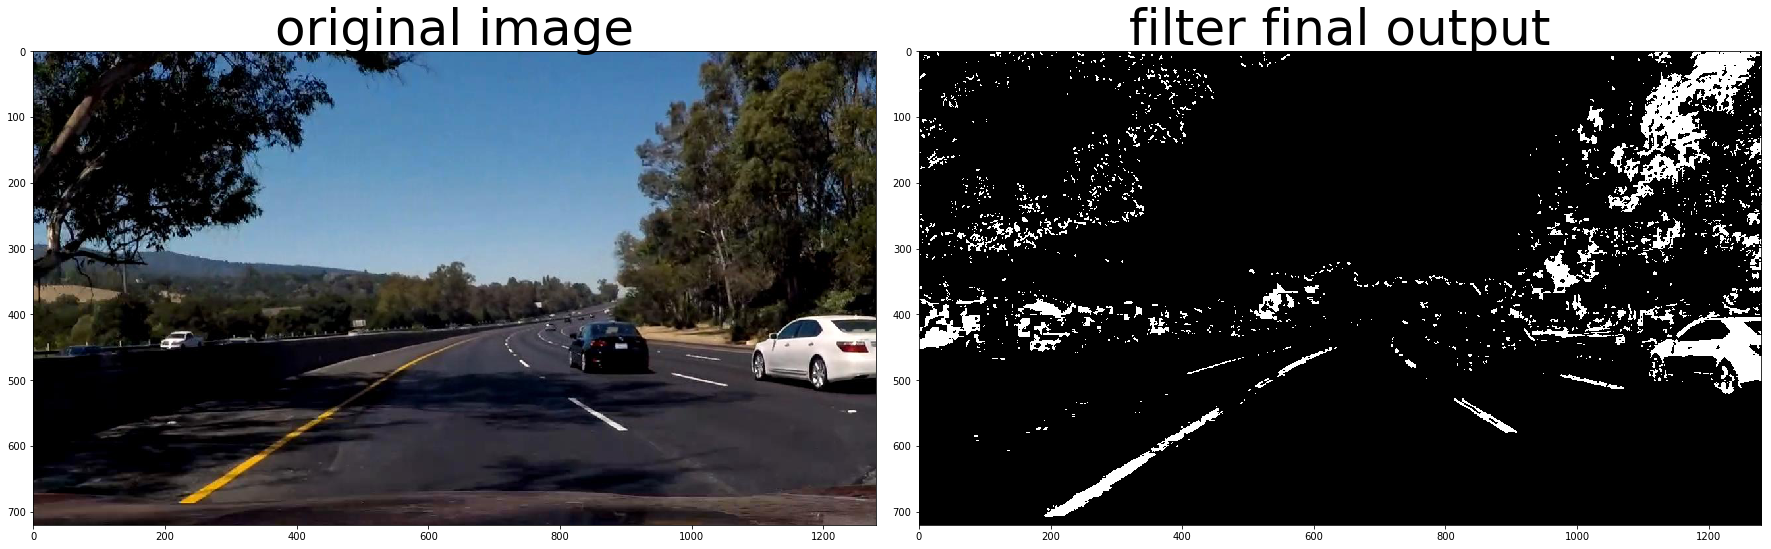

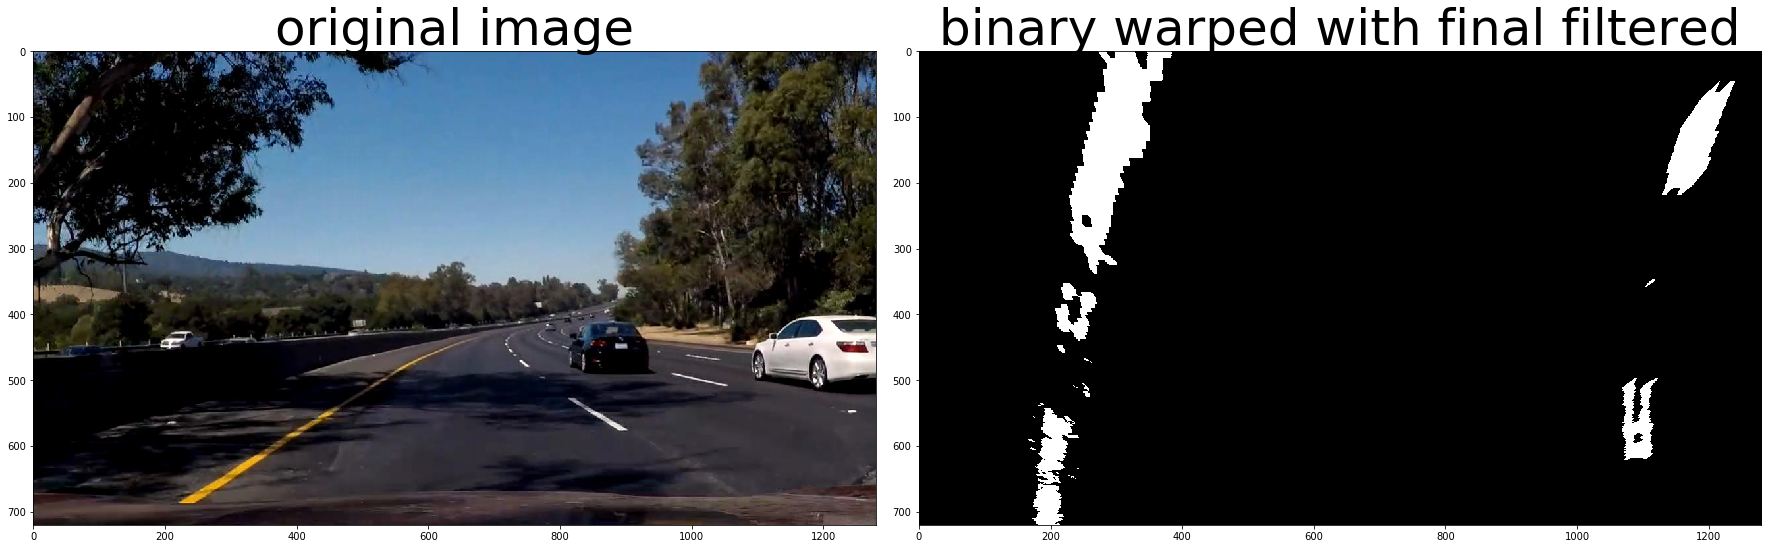

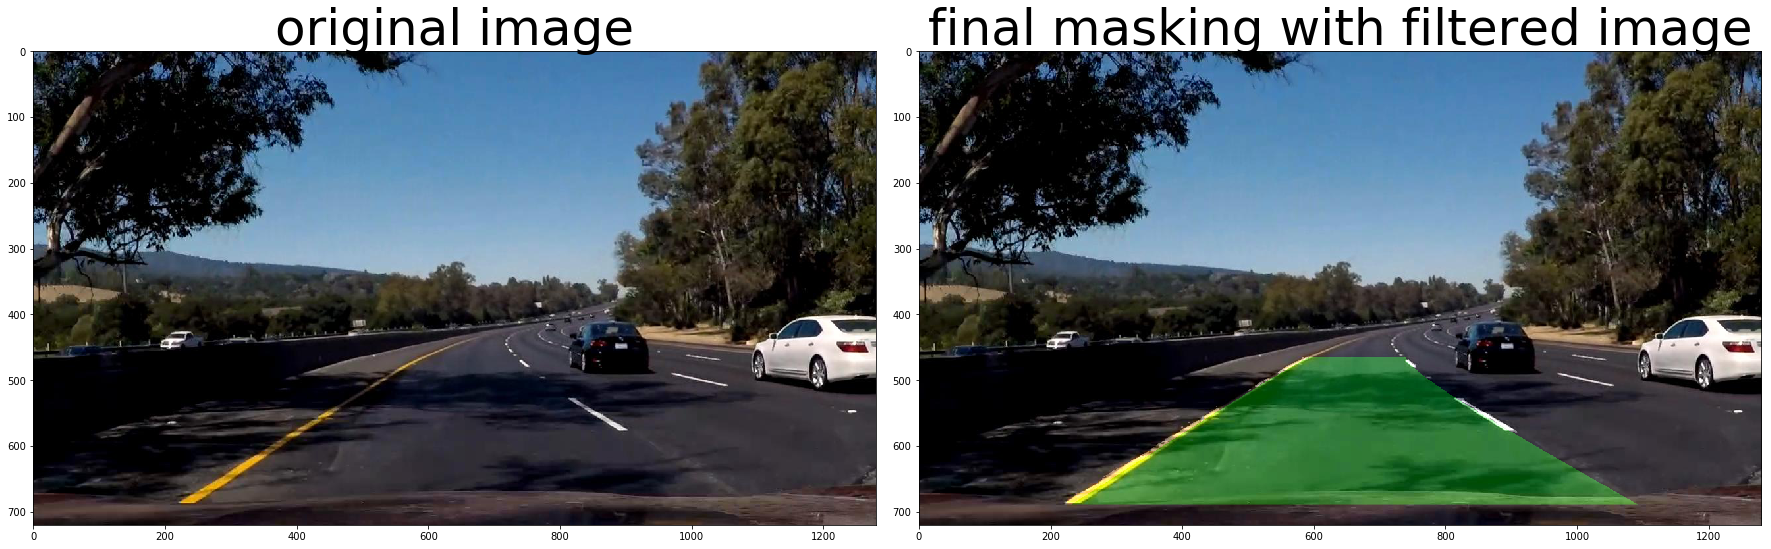

In [6]:
#initialize global variables
prev_left_fit = np.zeros(3)
prev_right_fit = np.zeros(3)
prev_leftx_base = 0
prev_rightx_base = 0
mw_leftx_base = np.zeros(3)
mw_rightx_base = np.zeros(3)
total_fail = 0

#test HLS, HSV, Yellow, and White lane grabber
sobel_thresh = (25, 255)
mag_thresh = (50, 100)
S_thresh = (80, 255)
H_thresh= (20, 30)

x_binary = abs_sobel_thresh(undist, 'x', 5, sobel_thresh)
y_binary = abs_sobel_thresh(undist, 'y', 3, sobel_thresh)
S_binary = HLS_threshold(undist, 'S', S_thresh)
H_binary = HLS_threshold(undist, 'H', H_thresh)
W_binary = white_selector(undist)
Y_binary = yellow_selector(undist)

color_output = OR_binaries(OR_binaries(W_binary, Y_binary), AND_binaries(S_binary, H_binary))
grad_output = blur = cv2.GaussianBlur(AND_binaries(x_binary, y_binary),(5,5),0)
output = OR_binaries(color_output, grad_output)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(x_binary, cmap='gray')
ax1.set_title('x_binary', fontsize=50)
ax2.imshow(y_binary, cmap='gray')
ax2.set_title('y_binary', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/xbinary_ybinary.png')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(S_binary, cmap='gray')
ax1.set_title('S_binary', fontsize=50)
ax2.imshow(H_binary, cmap='gray')
ax2.set_title('H_binary', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/Sbinary_Hbinary.png')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(W_binary, cmap='gray')
ax1.set_title('W_binary', fontsize=50)
ax2.imshow(Y_binary, cmap='gray')
ax2.set_title('Y_binary', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/Wbinary_Ybinary.png')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(color_output, cmap='gray')
ax1.set_title('color output (W or Y) or (H and S)', fontsize=50)
ax2.imshow(grad_output, cmap='gray')
ax2.set_title('gaussian blurred x and y', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/colorCombined_gaussianxandy.png')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(testimg)
ax1.set_title('original image', fontsize=50)
ax2.imshow(output, cmap='gray')
ax2.set_title('filter final output', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/orig_filteredFinal.png')

#now do save_mask on the filtered image
binary_warped, M, Minv = perspective_transform(output)
left_fit, right_fit = fit_lines(binary_warped)
result = save_mask(testimg, binary_warped, left_fit, right_fit, Minv)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(testimg)
ax1.set_title('original image', fontsize=50)
ax2.imshow(binary_warped, cmap='gray')
ax2.set_title('binary warped with final filtered', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/orig_finalFilteredWarpedBinary.png')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(testimg)
ax1.set_title('original image', fontsize=50)
ax2.imshow(result)
ax2.set_title('final masking with filtered image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/orig_finalMaskFiltered.png')

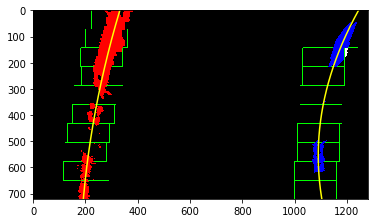

In [7]:
#initialize global variables
prev_left_fit = np.zeros(3)
prev_right_fit = np.zeros(3)
prev_leftx_base = 0
prev_rightx_base = 0
mw_leftx_base = np.zeros(3)
mw_rightx_base = np.zeros(3)
total_fail = 0
#plot windows and fit lines as well as save the plt to a file
plot_windows(binary_warped,left_fit,right_fit)

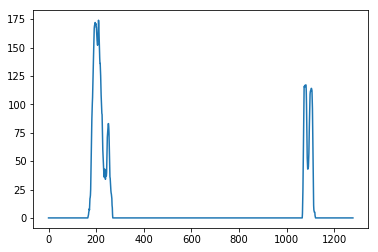

In [8]:
#histogram test after filtering
img = binary_warped

histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
plt.plot(histogram)
plt.savefig('output_images/histogram_finalFilteredWarpedBinary.png')

In [9]:
#initialize global variables
prev_left_fit = np.zeros(3)
prev_right_fit = np.zeros(3)
prev_leftx_base = 0
prev_rightx_base = 0
mw_leftx_base = np.zeros(3)
mw_rightx_base = np.zeros(3)
total_fail = 0

#test curvature and lanecenter measurement
testimg = mpimg.imread('failed_images/failed290.jpg')
print(testimg.shape)
mtx, dist = calibrate_camera()
undist = undistort(testimg,mtx,dist)
filtered = filter(undist)
warped, M, Minv = perspective_transform(filtered)
left_fit, right_fit = fit_lines(binary_warped)


left_curve_rad, right_curve_rad = get_curvature(binary_warped,left_fit,right_fit)
average_curve_rad = (left_curve_rad + right_curve_rad)/2
curvature_string = "Radius of curvature: %.2f m" % average_curve_rad
print(curvature_string)

# compute the offset from the center
offset_string = "Center offset: %.2f m" % get_lanecenter(binary_warped,left_fit,right_fit)
print(offset_string)

(720, 1280, 3)
Radius of curvature: 724.61 m
Center offset: -0.04 m


1494.92545132 1917.23850834


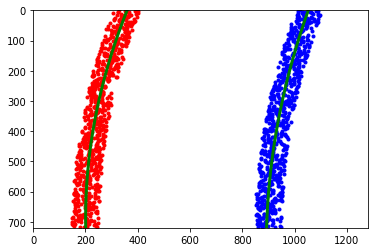

In [10]:
# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1926.74 1908.48

(720, 1280, 3)
left and right curvatures:
(839.9456124509361, 888.77471644424782)


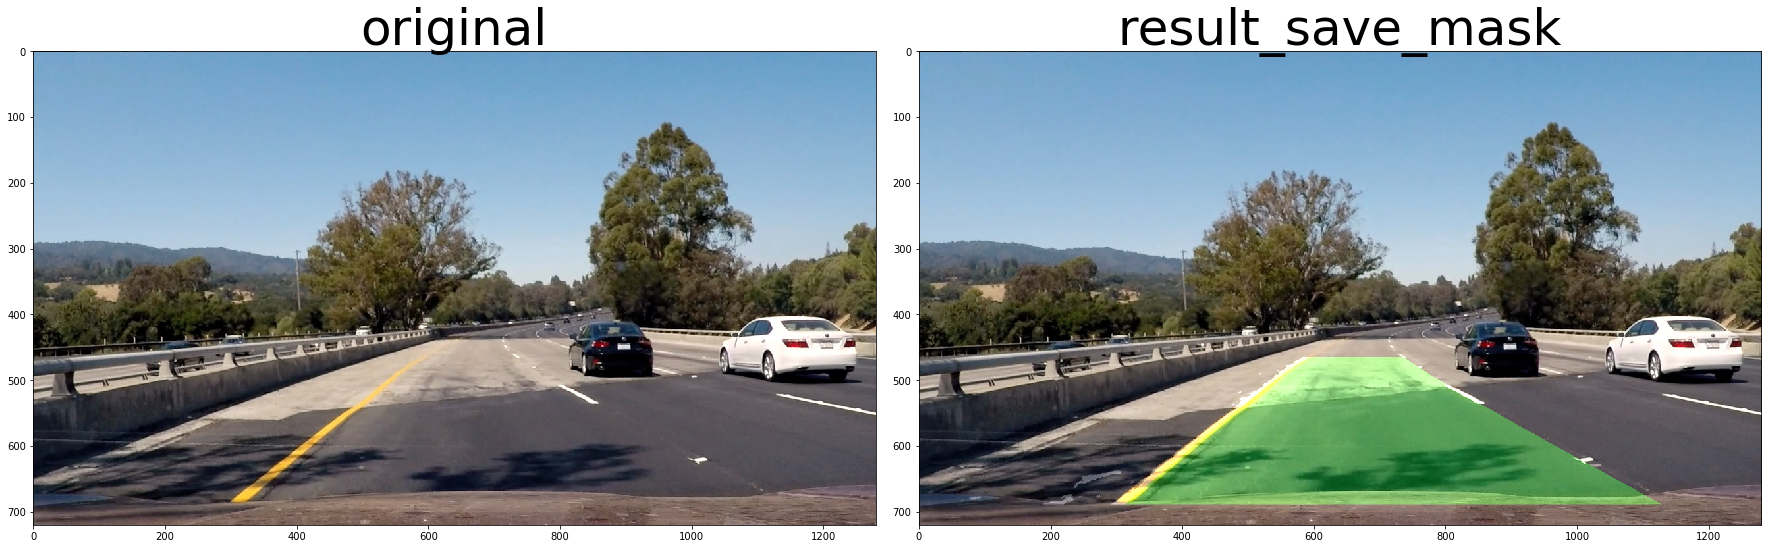

In [11]:
#initialize global variables
prev_left_fit = np.zeros(3)
prev_right_fit = np.zeros(3)
prev_leftx_base = 0
prev_rightx_base = 0
mw_leftx_base = np.zeros(3)
mw_rightx_base = np.zeros(3)
total_fail = 0

#test sliding windows of the next frame having already fit the lines for the previous frame
testimg = mpimg.imread('test_images/test4.jpg')
print(testimg.shape)
mtx, dist = calibrate_camera()
undist = undistort(testimg,mtx,dist)
warped, M, Minv = perspective_transform(undist)
binary_warped = hls_select(warped, thresh=(90, 255))
left_fit, right_fit = fit_lines(binary_warped)
left_fit, right_fit = fit_nextlines(binary_warped, left_fit, right_fit)
result = save_mask(testimg, binary_warped, left_fit, right_fit, Minv)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(testimg)
ax1.set_title('original', fontsize=50)
ax2.imshow(result, cmap='gray')
ax2.set_title('result_save_mask', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

print("left and right curvatures:")
print(get_curvature(binary_warped,left_fit,right_fit))

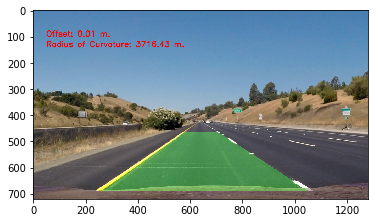

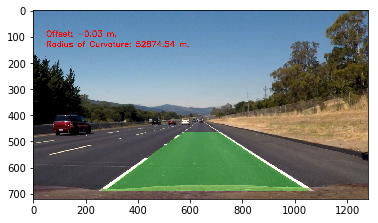

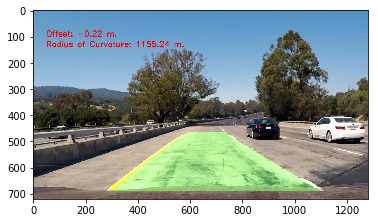

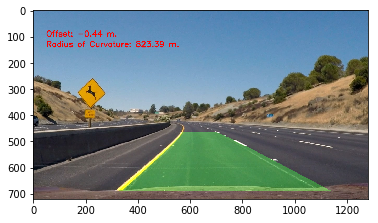

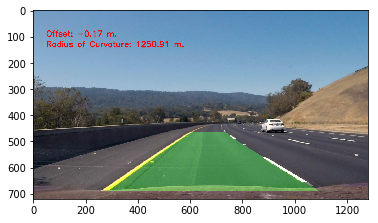

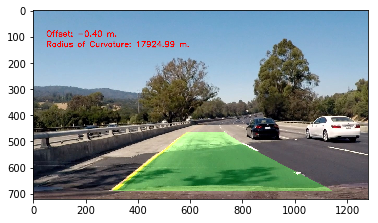

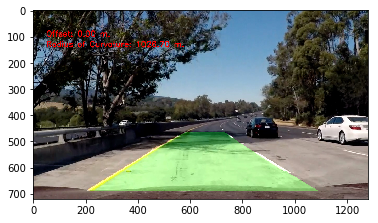

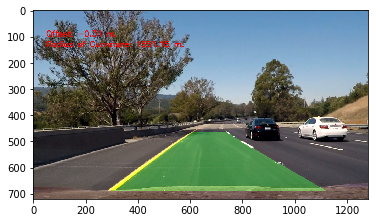

In [12]:
#initially calibrate camera
mtx, dist = calibrate_camera() 
#testing and playing around with images in the test_images folder
images = glob.glob('test_images/*.jpg')

for fname in images:
    #initialize global variables
    prev_left_fit = np.zeros(3)
    prev_right_fit = np.zeros(3)
    prev_leftx_base = 0
    prev_rightx_base = 0
    mw_leftx_base = np.zeros(3)
    mw_rightx_base = np.zeros(3)
    total_fail = 0
    
    image = mpimg.imread(fname)
    processed_image = process_image(image)
    plt.figure()
    plt.imshow(processed_image)  

In [13]:
#initialize global variables
prev_left_fit = np.zeros(3)
prev_right_fit = np.zeros(3)
prev_leftx_base = 0
prev_rightx_base = 0
mw_leftx_base = np.zeros(3)
mw_rightx_base = np.zeros(3)
total_fail = 0

#initially calibrate camera
mtx, dist = calibrate_camera() 

video_output = 'result.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("project_video.mp4")
#clip1 = VideoFileClip("project_video.mp4").subclip(0,1)
result_clip = clip1.fl_image(process_image)
#%time result_clip.write_videofile(video_output, audio=False)
%time result_clip.write_videofile(video_output, audio=False)
print(total_fail)

[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4


100%|█████████████████████████████████████▉| 1260/1261 [05:36<00:00,  3.62it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result.mp4 

Wall time: 5min 38s
393


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))
